# Install and Import Dependencies 

In [ ]:
!pip3 install torch torchvision torchaudio
# MacOS Binaries dont support CUDA, install from source if CUDA is needed

In [ ]:
# install transformers library
!pip3 install transformers

In [ ]:
# install natural language tool kit library
!pip3 install nltk

In [ ]:
# install pandas
!pip3 install pandas

In [ ]:
# install seaborn
!pip3 install seaborn

In [2]:
#for data preprocessing
from transformers import pipeline, GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from csv import reader
from pathlib import Path
from collections import defaultdict
import ast # for json string of list of dicts to list of dicts
import re
import nltk
nltk.download('punkt')
import pandas as pd
import math
import seaborn as sns
import numpy as np

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# for the actual model
import os
import time
import datetime
from transformers import GPT2LMHeadModel, GPT2Config, GPT2ForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import random

In [4]:
# for evaluation
import matplotlib.pyplot as plt

# Custom Formatter

In [4]:
# Method to arrange subrecipe ingredients into groups by ingredient type
def arrange_into_sub_groups (ingredients):
    ing_list = []
    for key in ingredients:
      key_ = key.replace(':', '')
      object = defaultdict(list)
      for ing in ingredients[key][0]:
        object[ing["type"]].append(ing["ingredient"])
      ing_list.append({key_: dict(object)})
    return ing_list

In [5]:
# Class to embed tokens in each text
class Formatter ():
    
    def _init_ (self):
        result = None
        raw = None
    
    def createInput (self):
        input = self.raw["keywords"]
        self.result += "<INPUT_START> "
        for i in range(4):
          self.result += input[i]+ " <NEXT_INPUT> "
        self.result += input[4]+ " <INPUT_END> "
          
    def process_ingredient_type(self, ingredients, typeOf):
        self.result +=  "<"+typeOf+"_START> "
        for i in range(0, len(ingredients)):
            # missed "recipe follows" ingredients when scraping
            if "recipe follows" in ingredients[i]:
              continue
            self.result +=  ingredients[i]
            if i == len(ingredients)-1:
                self.result += " <"+typeOf+"_END> "
            else:
                self.result +=  " <NEXT_"+typeOf+"> "
        
    def process_sub_group (self, group, typeOf):
        self.result +=  "<"+typeOf+"_INGREDIENTS_START> "
        if "premade" in group:
            self.process_ingredient_type(group["premade"], "PREMADE")
        if "prep" in group:
            self.process_ingredient_type(group["prep"], "PREP")
        if "fat" in group:
            self.process_ingredient_type(group["fat"], "FAT")
        if "structural" in group:
            self.process_ingredient_type(group["structural"], "STRUCTURAL")
        if "moistening" in group:
            self.process_ingredient_type(group["moistening"], "MOISTENING")
        if "sweetener" in group:
            self.process_ingredient_type(group["sweetener"], "SWEETENER")
        if "leavener" in group:
            self.process_ingredient_type(group["leavener"], "LEAVENER")
        if "flavoring" in group:
            self.process_ingredient_type(group["flavoring"], "FLAVORING")
        self.result +=  "<"+typeOf+"_INGREDIENTS_END> "
        
    def processLabel(self, text):
        return re.sub(r"[^a-zA-Z]+", '', text).strip()
        
        
    def createIngredients (self):
        
        ingredients = self.raw["ingredients"]
        self.result += "<INGREDIENTS_START> "
        # group_names = [k for d in ingredients for k in d.keys()]
        # add by group
        for group in ingredients:
          key = list(group.keys())[0]
          self.process_sub_group(group[key], self.processLabel(key.upper()))
        self.result += "<INGREDIENTS_END> "
        
            
    def createSteps (self):
        steps = self.raw["steps"]
        self.result += "<STEP_START> "
        for i in range(0, len(steps)):
            self.result += steps[i]
            if i == len(steps)-1:
                self.result += " <STEP_END> "
            else:
                self.result += " <NEXT_STEP> "    
    
    def createTitle (self):
        self.result += "<TITLE_START> " + self.raw["title"] + " <TITLE_END> "
    
    def createYield (self):
        self.result += "<YIELD_START> " + self.raw["yield"] + " <YIELD_END> "
        
    
    def buildString (self):
        self.result = "<RECIPE_START> "
        self.createInput()
        self.createYield()
        self.createIngredients()
        self.createSteps()
        self.createTitle()
        self.result += "<RECIPE_END>"
    
    def buildIngredientString(self):
      self.createInput()
      self.createYield()
      self.createIngredients()

    def buildStepString(self):
      self.createInput()
      self.createSteps()
    
    def run (self, object):
        self.raw = object
        self.buildString()
  
    def runIngredients (self, object):
        self.raw = object
        self.result = ""
        self.buildIngredientString()
    
    def runSteps (self, object):
        self.raw = object
        self.result = ""
        self.buildStepString()
    
    def getString (self):
        return self.result
    

# Custom Embed Tokens Tokenizer

In [6]:
my_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", do_lower_case=False)
special_tokens = {
    "additional_special_tokens": [
        "<TITLE_START>",
        "<TITLE_END>",
        "<YIELD_START>",
        "<YIELD_END>",
        "<STEP_START>",
        "<NEXT_STEP>",
        "<STEP_END>",
        "<INGREDIENTS_START>",
        "<NEXT_INGREDIENT>",
        "<INGREDIENTS_END>",
        "<PREMADE_START>",
        "<NEXT_PREMADE>",
        "<PREMADE_END>",
        "<PREP_START>",
        "<NEXT_PREP>",
        "<PREP_END>",
        "<STRUCTURAL_START>",
        "<NEXT_STRUCTURAL>",
        "<STRUCTURAL_END>",
        "<FAT_START>",
        "<NEXT_FAT>",
        "<FAT_END>",
        "<FLAVORING_START>",
        "<NEXT_FLAVORING>",
        "<FLAVORING_END>",
        "<SWEETENER_START>",
        "<NEXT_SWEETENER>",
        "<SWEETENER_END>",
        "<MOISTENING_START>",
        "<NEXT_MOISTENING>",
        "<MOISTENING_END>",
        "<LEAVENER_START>",
        "<NEXT_LEAVENER>",
        "<LEAVENER_END>",
        "<RECIPE_START>",
        "<RECIPE_END>",
        "<INPUT_START>",
        "<INPUT_END>",
        "<NEXT_INPUT>",
        "<MAIN_INGREDIENTS_START>",
         "<MAIN_INGREDIENTS_END>",
        "<FROSTING_INGREDIENTS_START>",
         "<FROSTING_INGREDIENTS_END>",
        "<FILLING_INGREDIENTS_START>",
         "<FILLING_INGREDIENTS_END>",
        "<FROSTING_INGREDIENTS_START>",
         "<FROSTING_INGREDIENTS_END>",
        "<GANACHE_INGREDIENTS_START>",
         "<GANACHE_INGREDIENTS_END>",
         "<CURD_INGREDIENTS_START>",
         "<CURD_INGREDIENTS_END>",
         "<SYRUP_INGREDIENTS_START>",
         "<SYRUP_INGREDIENTS_END>",
         "<TOPPING_INGREDIENTS_START>",
         "<TOPPING_INGREDIENTS_END>",
         "<CRUST_INGREDIENTS_START>",
         "<CRUST_INGREDIENTS_END>",
         "<TOPPING_INGREDIENTS_START>",
         "<TOPPING_INGREDIENTS_END>"
    ]
}

my_tokenizer.add_special_tokens(special_tokens)
my_tokenizer.add_special_tokens({'pad_token': '<PAD>'})

end_token_id = my_tokenizer.convert_tokens_to_ids(["<RECIPE_END>"])[0]
pad_token_id = my_tokenizer.convert_tokens_to_ids(["<PAD>"])[0]


# Import Data

In [7]:
# our data from csv
df = pd.read_csv('https://raw.githubusercontent.com/lail-lei/nlp-cupcakes/main/csvs/baking_instructions_4852.csv')
#df = pd.read_csv('https://raw.githubusercontent.com/lail-lei/nlp-cupcakes/main/csvs/.csv')
#df = pd.read_csv('https://raw.githubusercontent.com/lail-lei/nlp-cupcakes/main/csvs/just_cakes_2345.csv')

In [8]:
# method to create docs from csv
def createDocs ():
    
  # create objects, and save to list
  objects = []
  # randomize 
  # The frac keyword argument specifies the fraction of rows to return in the random sample,  
  # so frac=1 means return all rows (in random order).
  # specifying drop=True prevents .reset_index from creating a column containing the old index entries.
  random = df.sample(frac=1, random_state=42).reset_index(drop=True) 

    
  for ind in random.index:
    obj = {}
    # for formatting
    fm = Formatter()
    obj["title"] = random['Title'][ind]
    obj["yield"] = random['Yield'][ind]
    obj["ingredients"] = arrange_into_sub_groups(ast.literal_eval(random['processed_ingredients'][ind]))
    obj["steps"] = ast.literal_eval(random['Steps'][ind])
    obj["keywords"] = ast.literal_eval(random["keywords"][ind]) 
    fm.run(obj) # format
    length = len(fm.getString().split())
    # save only the recipes less than or equal to
    # the embed token limit for gpt2 (768)
    if length <= 768:
      objects.append(fm.getString()) #and append formatted obj
  
  return objects

In [9]:
# now this is a list of recipes with embed tokens 
docs = createDocs()
len(docs)

4452

In [10]:
docs[1004]

'<RECIPE_START> <INPUT_START> cupcakes <NEXT_INPUT> combined <NEXT_INPUT> add <NEXT_INPUT> half <NEXT_INPUT> egg <INPUT_END> <YIELD_START> 12 cupcakes  <YIELD_END> <INGREDIENTS_START> <MAIN_INGREDIENTS_START> <FAT_START> 6 tbsp unsalted butter room temperature <NEXT_FAT> 1 1/2 tbsp vegetable oil <FAT_END> <STRUCTURAL_START> 1 1/4 cups all purpose flour <NEXT_STRUCTURAL> 2 large eggs divided <STRUCTURAL_END> <MOISTENING_START> 1/2 cup 2 tbsp milk <MOISTENING_END> <SWEETENER_START> 3/4 cup sugar <SWEETENER_END> <LEAVENER_START> 1 1/4 tsp baking powder <LEAVENER_END> <FLAVORING_START> 1/4 tsp salt <NEXT_FLAVORING> 1 1/2 tsp vanilla extract <NEXT_FLAVORING> 1/4 cup sprinkles  <FLAVORING_END> <MAIN_INGREDIENTS_END> <FROSTING_INGREDIENTS_START> <FAT_START> 1 cup unsalted butter room temperature <FAT_END> <MOISTENING_START> 2 4 tbsp water or heavy cream <MOISTENING_END> <SWEETENER_START> 4 cups powdered sugar <SWEETENER_END> <FLAVORING_START> 1 tsp vanilla extract <NEXT_FLAVORING> Pinch or tw

# Create Training and Testing Datasets

In [11]:
# batch size is the number of 768 token examples fed to the model
# at each iteration
batch_size = 4

Every tensor passed to the model should be the same length. If the recipe is shorter 
than 768 tokens, it will be padded to a length of 768 using the padding token. 
In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

In [12]:
class GPT2Dataset(Dataset):

  # max length is number of embed tokens for gpt2 small
  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      encodings_dict = tokenizer(txt, truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [13]:
# Dataset object loads training or test data into memory

dataset = GPT2Dataset(docs, my_tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,561 training samples
  891 validation samples


In [14]:
train_dataset[0]

(tensor([50291, 50293, 30119,   563, 50295,   431,   417, 50295,    79,   342,
         50295,    82,  2501,   500, 50295,   293,  2144, 50294, 50259,    23,
           284,   838,  5207,   286,  2508, 50260, 50264, 50310, 50276,    16,
          4859,  5576, 29590,  9215,  2005,   656,  1402,  5207,   379,  2119,
          5951, 50278, 50282,    18, 30064,  7543, 50284, 50279,    16, 23179,
          8268,   500,  8469,   364, 18577, 50280,    16,    14,    17,  6508,
          6029,  2945, 37624, 20132, 50280,    16,    14,    19, 22326, 43951,
          8268, 50281, 50311, 50300, 50273,    19,  1588,  5935,   331,   349,
           591, 50275, 50285,    16,  1478, 25799,   460,  6029,  2945, 38784,
          7545, 50287, 50279,    17,  7090,   443, 11567, 18989,   880, 50281,
         50301, 50308, 50285,    16,  6508,  4692,  4334,  8566, 50287, 50282,
            16, 33107,  7543, 50284, 50309, 50266, 50261, 12050,   262, 20048,
          3771, 25080,   262, 14361,   284, 13803,  

In [15]:
# DataLoader object fetches data from a Dataset 
# and serves the data up in batches.

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetuning the model!

In [18]:
# set configuration
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
# configuration.gradient_checkpointing: True
# configuration.n_head = 12
# configuration.n_layer = 12
# #increase dropout
# configuration.resid_pdrop = 0.25
# configuration.attn_pdrop = 0.25
# configuration.embd_pdrop = 0.25
configuration

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 8,
  "n_inner": null,
  "n_layer": 8,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.8.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [19]:
# instantiate the model
# The GPT2 Model transformer with a language modeling head on top 
# (linear layer with weights tied to the input embeddings).
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)


Some weights of the model checkpoint at gpt2 were not used when initializing GPT2LMHeadModel: ['h.11.mlp.c_proj.weight', 'h.9.mlp.c_proj.weight', 'h.11.attn.c_proj.weight', 'h.9.ln_1.bias', 'h.11.attn.c_attn.weight', 'h.9.ln_2.weight', 'h.8.ln_2.weight', 'h.10.mlp.c_proj.bias', 'h.11.attn.c_attn.bias', 'h.11.ln_1.weight', 'h.8.attn.c_attn.bias', 'h.8.attn.c_attn.weight', 'h.8.mlp.c_proj.bias', 'h.11.mlp.c_fc.bias', 'h.11.mlp.c_proj.bias', 'h.9.attn.bias', 'h.8.attn.c_proj.weight', 'h.11.attn.c_proj.bias', 'h.11.ln_1.bias', 'h.8.ln_2.bias', 'h.8.mlp.c_fc.bias', 'h.9.mlp.c_fc.bias', 'h.10.ln_2.weight', 'h.9.mlp.c_proj.bias', 'h.9.attn.c_proj.weight', 'h.8.attn.c_proj.bias', 'h.8.mlp.c_proj.weight', 'h.10.attn.c_attn.bias', 'h.10.mlp.c_fc.weight', 'h.8.ln_1.bias', 'h.10.ln_1.weight', 'h.11.ln_2.weight', 'h.11.mlp.c_fc.weight', 'h.10.mlp.c_proj.weight', 'h.8.ln_1.weight', 'h.9.attn.c_proj.bias', 'h.11.ln_2.bias', 'h.9.attn.c_attn.bias', 'h.10.attn.bias', 'h.9.ln_2.bias', 'h.8.attn.bias', '

In [21]:
# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(my_tokenizer))

# fix model padding token id
model.config.pad_token_id = pad_token_id
#model.config.gradient_accumulation_steps = 10;

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [77]:
#decrease dropout
# model.config.resid_pdrop = 0.1
# model.config.attn_pdrop = 0.1
# model.config.embd_pdrop = 0.1

In [78]:
# freeze embedding layer
# for name, param in model.named_parameters():
#     if param.requires_grad and ('wte' in name or 'wpe' in name):
#         param.requires_grad = False
# freeze first 2 layers
# for name, param in model.named_parameters():
#     if param.requires_grad and ('h.0.' in name 
#                                 or 'h.1.' in name 
#                                 or 'h.2.' in name 
#                                 or 'h.3.' in name 
#                                 or 'h.4.' in name
#                                 or 'h.5.' in name
#                                 or 'h.6.' in name
#                                 or 'h.7.' in name
#                                 or 'h.8.' in name
#                                 or 'h.9.' in name
#                                 or 'h.10.' in name
#                                 or 'h.11.' in name):
#         param.requires_grad = False
    



In [79]:
# unfreeze embedding layer
# for name, param in model.named_parameters():
#     if 'h.0.' in name:
#         param.requires_grad = True


In [80]:
# for name, param in model.named_parameters():
#     print(name)
#     print(param.requires_grad)

In [22]:
# some parameters I cooked up that work reasonably well
epochs = 1
learning_rate = 9e-4
#learning_rate = 6e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 200

In [23]:
#Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon,
#                   weight_decay = 2,
#                   correct_bias = False,
                )

# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [24]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [25]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [37]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time() # reset timer

    total_train_loss = 0 # reset training loss

    model.train() # set model to "training" mode
    
    # Always clear any previously calculated gradients before performing a
    # backward pass. PyTorch doesn't do this automatically because 
    # accumulating the gradients is "convenient while training RNNs". 
    # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
    model.zero_grad()   
    
    # keep track of ste
    process_count = 0;

    # for each step and batch (group of examples) in our training dataset
    # steps = training samples / batch size 
    for step, batch in enumerate(train_dataloader):
        
#         print(step)
        
        # Unpack this training batch from our dataloader. As we unpack the batch,
        # we'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains two pytorch tensors:
        #   [0]: input ids /labels 
        #   [1]: attention masks
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        
        # Model arguments: 

        # The INPUT_IDS are often the only required parameters
        # to be passed to the model as input. 
        # They are token indices, numerical representations of tokens 
        # building the sequences that will be used as input by the model.
        # Tokenize text (products of gpt2 tokenizer) are converted into IDs
        # which are understandable by the model. 
        # This can be done by directly feeding the sentence to the tokenizer, 
        # which leverages the Rust implementation of huggingface/tokenizers for peak performance.
        
        # LABELS are an optional argument 
        # which can be passed in order for the model to compute the loss itself. 
        # These labels should be the expected prediction of the model: 
        # it will use the standard loss in order to compute the loss 
        # between its predictions and the expected value (the label).
        
        # Since BIM is working on generation, the input ids and 
        # the labels are the same thing- the predicted value of the generated text
        # is the generated text itself 

        # The ATTENTION_MASK argument indicates to the model 
        # which tokens should be attended to, and which should not.
        # Since each training "sample" in the batch must be the same length (768 tokens)
        # shorter samples included special padding tokens which will be ignored by the model
        # The attention mask, b_masks, is a binary tensor 
        # indicating the position of the padded indices (and other tokens) 
        # so that the model does not attend to them.
        
        # Here, we perform a forward pass (evaluate the model on this training batch).
        # returns a tuple containing various elements depending on the configuration.
        # Based on current config, outputs include:
        # language modeling loss, prediction scores of the language modeling head,
        # and past: a tensor that contains pre-computed 
        # hidden-states (key and values in the attention blocks). 
        # Can be used (see past input) to speed up sequential decoding. 
        # When past is used as input, the input_ids which have their past 
        # given to this model should not be passed as input_ids 
        # as they have already been computed.
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

      
        loss = outputs[0]  
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval() # set mode to evaluate 
            # now we generate a sample
            
            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000), #The id of the beginning-of-sequence token.
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, my_tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train() # now let's set mode back to train

        # backward pass- compute the gradients for each parameter from loss
        loss.backward() 
        process_count += 1
        
        if process_count == batch_size:
            process_count = 0    
            optimizer.step()  # update the parameters using gradients computed in backward pass
            scheduler.step() # change the learning rate as the training loop progresses
                            # warm up vs actual training 
            optimizer.zero_grad()
            model.zero_grad() # Reset gradients tensors
        
# if we are at end of batch, we can do gradients (if (step+1) % accumulation_steps == 0:  
#optimizer.step() scheduler.step() model.zero_grad() 

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time() # reset timer

    model.eval() # set mode to evaluate 
    
    # set variables to 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device) # get inputs
        b_labels = batch[0].to(device) # get labels
        b_masks = batch[1].to(device) # get mask
        
        # no gradients! Disabling gradient calculation is useful for inference, 
        # when you are sure that you will not call Tensor.backward().
        with torch.no_grad():        
            # input the inputs 
            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
            # get the losss
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time,
            "Perplexity": math.exp(loss)
        }
    )
    
    print("Perplexity:", math.exp(loss))

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))




======== Epoch 1 / 1 ========
Training...
  Batch   200  of    891. Loss: 1.029552936553955.   Elapsed: 0:02:36.
0:  Liberationpastryleekcrumbpintdough8 servings6 tablespoons cold unsalted butter melted6 egg white1/2 cup packed light brown sugar3/4 cup granulated sugar1/4 teaspoon baking powder1 tablespoon cornstarch1 teaspoon salt1 1/2 teaspoons ground cinnamon1/2 teaspoon pure vanilla extract1 teaspoon ground nutmeg1/4 teaspoon grated nutmeg1/2 teaspoon ground cloves1/2 teaspoon ground nutmeg1/2 cup shortening3 tablespoons unsalted butter softened to room temperature1 large egg beaten3 tablespoons granulated sugar1 1/2 teaspoons pumpkin puree1/2 teaspoon salt1/2 teaspoon ground cinnamon1/4 teaspoon ground cloves1/4 teaspoon freshly grated nutmeg1/4 teaspoon ground ginger
  Batch   400  of    891. Loss: 0.7420405745506287.   Elapsed: 0:05:17.
0:  Namcupcakeswhitedessertgrahamchocolate16 cupcakes1 cup unsalted butter softened to room temperature3 1/2 cups cake flour2 large eggs room t

Let's view the summary of the training process.

In [38]:
# Display floats with two decimal places.
pd.set_option('precision', 3)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time,Perplexity
epoch,,,,,
1,0.953,0.953,0:11:53,0:01:05,3.937


In [86]:
# perplexity score
math.exp(loss)

2.9528208389507324

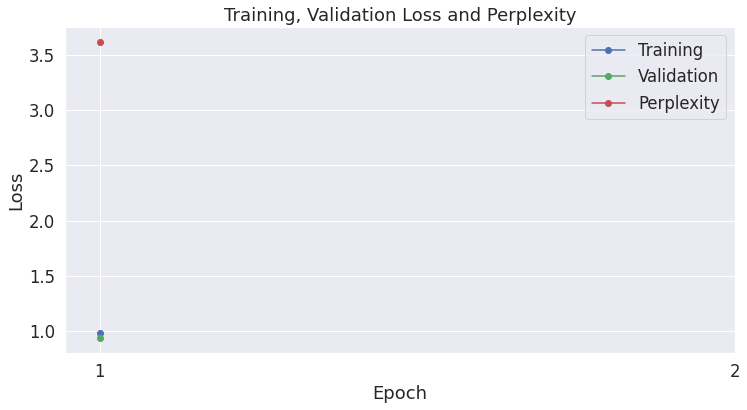

In [46]:
## Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.plot(df_stats['Perplexity'], 'r-o', label="Perplexity")

# Label the plot.
plt.title("Training, Validation Loss and Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

# Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Saving and Loading the Model

In [130]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_80-20-train_8_layers/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
my_tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_80-20-train/


('./model_80-20-train/tokenizer_config.json',
 './model_80-20-train/special_tokens_map.json',
 './model_80-20-train/vocab.json',
 './model_80-20-train/merges.txt',
 './model_80-20-train/added_tokens.json')

In [131]:
!ls -l --block-size=K ./model_80-20-train/

total 499960K
-rw-rw-r-- 1 ubuntu ubuntu      2K Jul 27 20:01 added_tokens.json
-rw-rw-r-- 1 ubuntu ubuntu      1K Jul 27 20:01 config.json
-rw-rw-r-- 1 ubuntu ubuntu    446K Jul 27 20:01 merges.txt
-rw-rw-r-- 1 ubuntu ubuntu 498610K Jul 27 20:01 pytorch_model.bin
-rw-rw-r-- 1 ubuntu ubuntu      2K Jul 27 20:01 special_tokens_map.json
-rw-rw-r-- 1 ubuntu ubuntu      1K Jul 27 20:01 tokenizer_config.json
-rw-rw-r-- 1 ubuntu ubuntu    878K Jul 27 20:01 vocab.json


In [132]:
!ls -l --block-size=M ./model_80-20-train/pytorch_model.bin

-rw-rw-r-- 1 ubuntu ubuntu 487M Jul 27 20:01 ./model_80-20-train/pytorch_model.bin


# LOAD an existing model

In [5]:
output_dir = './model_80-20-train/'
#Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
my_tokenizer = GPT2Tokenizer.from_pretrained(output_dir)

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50313, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


# Generate Text

In [7]:
model.eval()
prompt = "<RECIPE_START> <INPUT_START> cupcakes <NEXT_INPUT> brown sugar <NEXT_INPUT> marmalade <NEXT_INPUT> cayenne <NEXT_INPUT> bacon <NEXT_INPUT maple <INPUT_END>" 
generated = torch.tensor(my_tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=75, 
                                max_length = 1024,
                                top_p=0.95, 
                                num_return_sequences=70,
                                repetition_penalty = 1, 
                                no_repeat_ngram_size = 7, 
                                temperature=0.8 # previously 8
                                )

# for i, sample_output in enumerate(sample_outputs):
#   print("{}: {}\n\n".format(i, my_tokenizer.decode(sample_output, skip_special_tokens=False)))




# model.eval()

# prompt = "<RECIPE_START> <INPUT_START> cupcakes <INPUT_END> lemon <NEXT_INPUT> cream cheese <NEXT_INPUT> blueberry <NEXT_INPUT> berry <INPUT_END>"

# generated = torch.tensor(my_tokenizer.encode(prompt)).unsqueeze(0)
# generated = generated.to(device)

# print(generated)

# sample_outputs = model.generate(
#                                 generated, 
#                                 #bos_token_id=random.randint(1,30000),
#                                 do_sample=True,   
#                                 top_k=50, 
#                                 max_length = 768,
#                                 top_p=0.95, 
#                                 num_return_sequences=3,
#                                 repetition_penalty = 1,
#                                 no_repeat_ngram_size = 5, 
#                                 temperature=1
#                                 )

# for i, sample_output in enumerate(sample_outputs):
#   print("{}: {}\n\n".format(i, my_tokenizer.decode(sample_output, skip_special_tokens=False)))



# sample_outputs = model.generate(
#                                 generated, 
#                                 max_length = 1024,
#                                 do_sample=True,  
#                                 top_k = 50,
#                                 top_p=0.90, 
# #                                 bad_words_ids = exclude,
#                                 num_return_sequences=5,
    
                               
#                                 #bos_token_id=random.randint(1,30000),
# #                                 do_sample=True,   
# #                                 top_k=200, 
# #                                 max_length = 1024,
# #                                 top_p=0.90, 
# #                                 num_return_sequences=5,
# #                                 temperature=0.6
#                                 )


# for i, sample_output in enumerate(sample_outputs):
#   print("{}: {}\n\n".format(i, my_tokenizer.decode(sample_output, skip_special_tokens=False)))

In [8]:
decoded = []
for item in sample_outputs:
    decoded.append(my_tokenizer.decode(item, skip_special_tokens=False))

In [9]:
sample_dataframe = pd.DataFrame(data=decoded, columns = ["generated"])

In [10]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link( df, title = "thursday_70", filename = "thursday_70.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(sample_dataframe)